In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from time_series_influences.utils import split_time_series, match_train_time_block_index
from time_series_influences.influence_functions import compute_loo_linear_approx, empirical_IC_linear_approx
from time_series_influences.anomaly_detection import scale_influence_functions, eval_anomaly_detector
from time_series_influences.block_selection import compute_optimal_block_length

seed = 666
np.random.seed(seed)

In [3]:
data_path = "../data/univariate/UCR/data/"
data_dir = Path("../data/univariate/UCR/data/")
for file_name in os.listdir(data_path):
    if int(file_name[:3]) < 204:
        ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
        file_name_list = file_name[:-4].split('_')
        train_id, anomaly_start, anomaly_end = int(file_name_list[4]),int(file_name_list[5]),int(file_name_list[6])
        ts = ts.squeeze()
        ground_truth = np.zeros_like(ts)
        ground_truth[anomaly_start:anomaly_end] = 1.
        print('Dataset:',file_name_list[0]+'_'+file_name_list[3])
        print('Num. of Training: ',train_id)
        print('Num. of Test: ',len(ts)-train_id)
        print('Len. of Anomaly: ',anomaly_end-anomaly_start)
        print('Anomaly Ratio:', float((anomaly_end-anomaly_start))/len(ts))

#### point outlier detection

In [4]:
file_name = "037_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG1_5000_17210_17260.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 17210, 17260
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

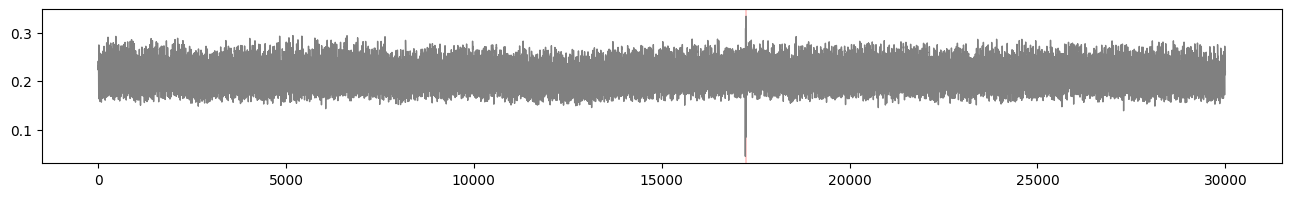

In [5]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.show()

In [6]:
block_length = compute_optimal_block_length(ts, 1000, 3000)

The optimal block length is:  52


In [7]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(29949, 52) (29949,)


In [8]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [9]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 29949/29949 [00:00<00:00, 79177.37it/s]


In [10]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

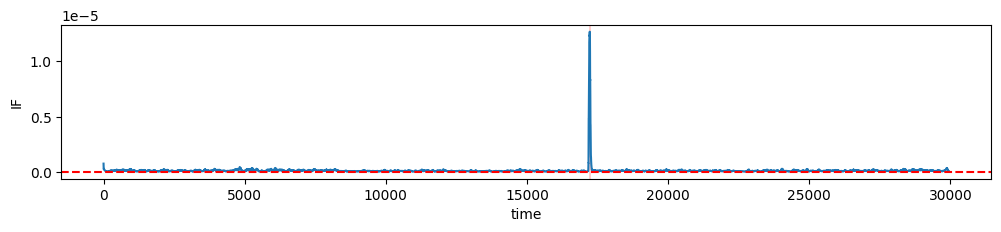

In [11]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [12]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length=block_length)

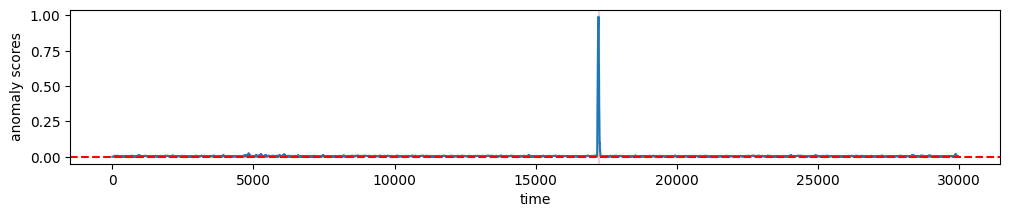

In [13]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [14]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

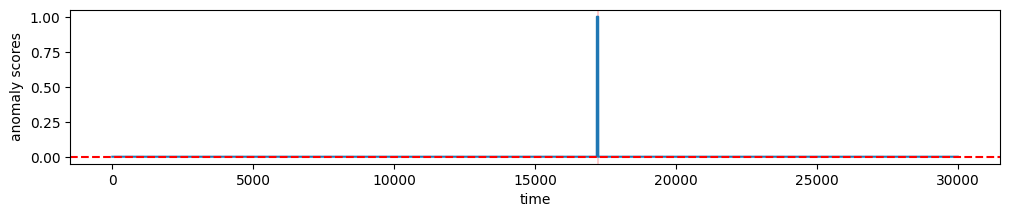

In [15]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [16]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

precision: 0.640 recall: 0.640 F1: 0.640 AUC: 1.000


#### change point detection

In [17]:
file_name = "042_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG6_7000_12190_12420.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 12190, 12420
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

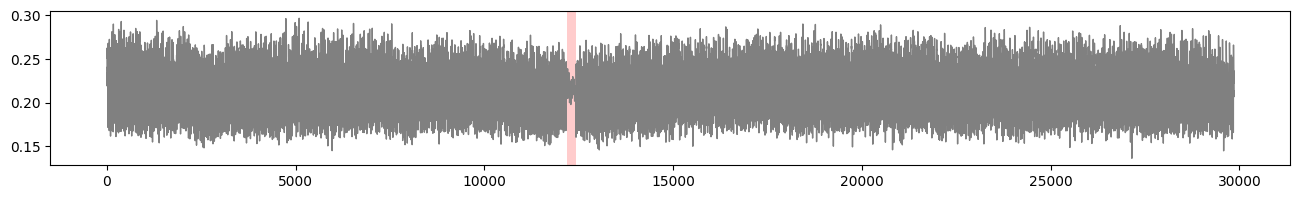

In [18]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.show()

In [19]:
block_length = compute_optimal_block_length(ts, 1000, 3000)

The optimal block length is:  52


In [20]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(29807, 52) (29807,)


In [21]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [22]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 29807/29807 [00:00<00:00, 79199.58it/s]


In [23]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

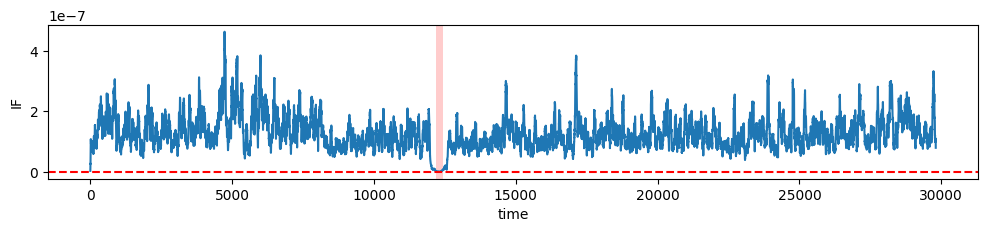

In [24]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [25]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

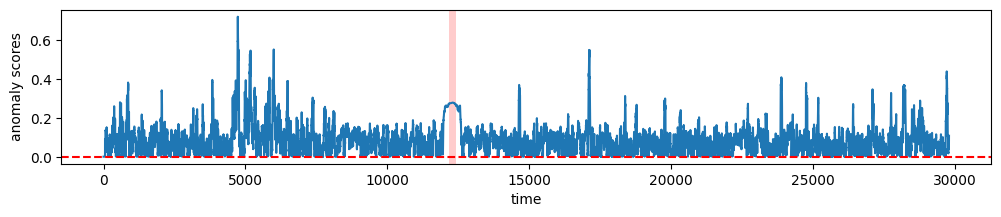

In [26]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [27]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

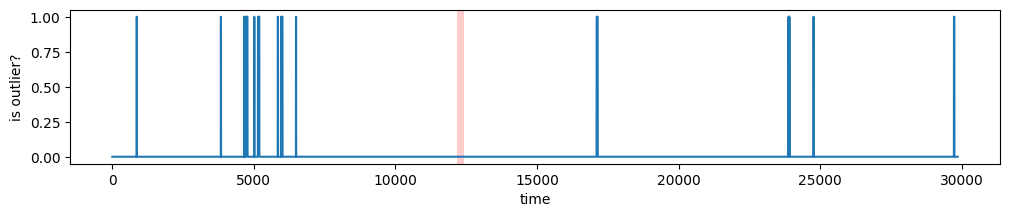

In [28]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [29]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

precision: 0.000 recall: 0.000 F1: 0.000 AUC: 0.975


#### anomaly pattern detection

In [30]:
file_name = "062_UCR_Anomaly_DISTORTEDgaitHunt1_18500_33070_33180.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 33070, 33180
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

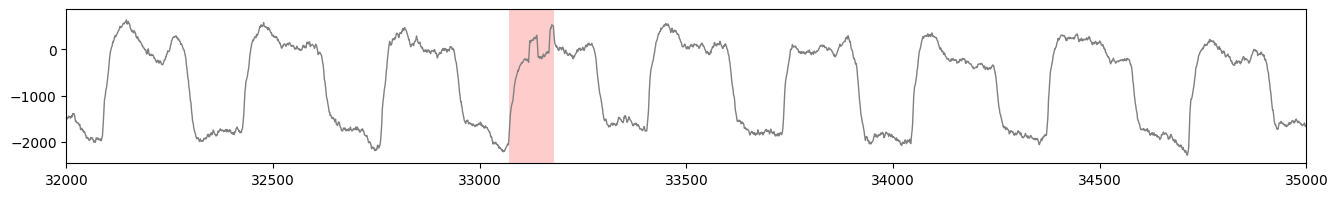

In [31]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.xlim(32000, 35000)
plt.show()

In [32]:
block_length = compute_optimal_block_length(ts, 1000, 3000)

The optimal block length is:  40


In [33]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(63960, 40) (63960,)


In [34]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [35]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 63960/63960 [00:00<00:00, 81965.53it/s]


In [36]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

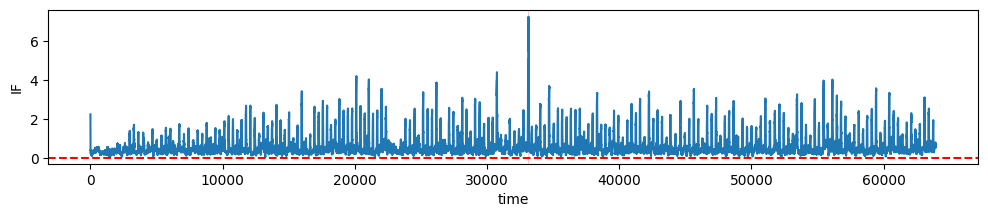

In [37]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [38]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

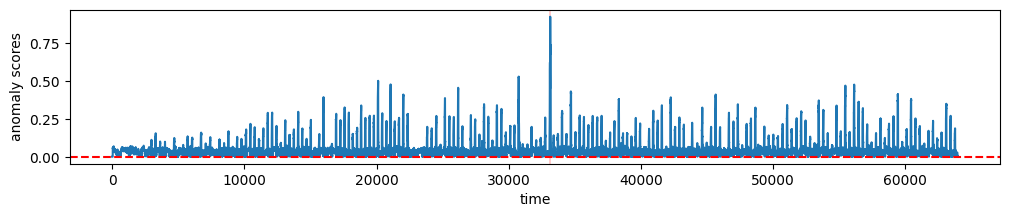

In [39]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [40]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

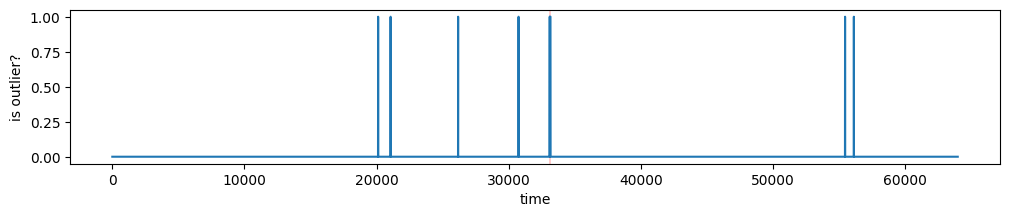

In [41]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [42]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

precision: 0.573 recall: 0.573 F1: 0.573 AUC: 0.924


#### noise detection

In [43]:
file_name = "003_UCR_Anomaly_DISTORTED3sddb40_35000_46600_46900.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 46600, 46900
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

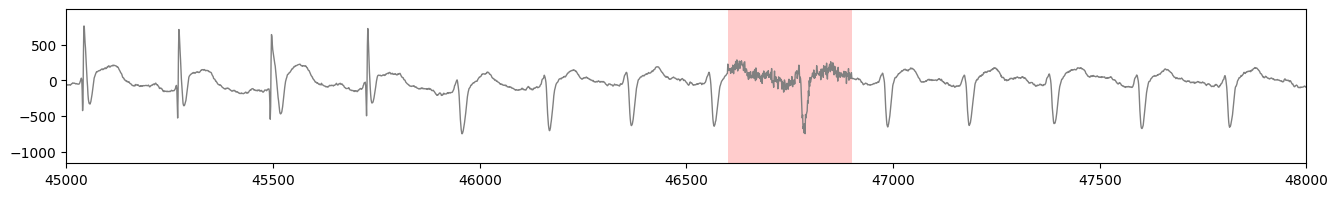

In [44]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.xlim(45000, 48000)
plt.show()

In [45]:
block_length = compute_optimal_block_length(ts, 1000, 3000)

The optimal block length is:  16


In [46]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(79984, 16) (79984,)


In [47]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [48]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 79984/79984 [00:00<00:00, 85296.44it/s]


In [49]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

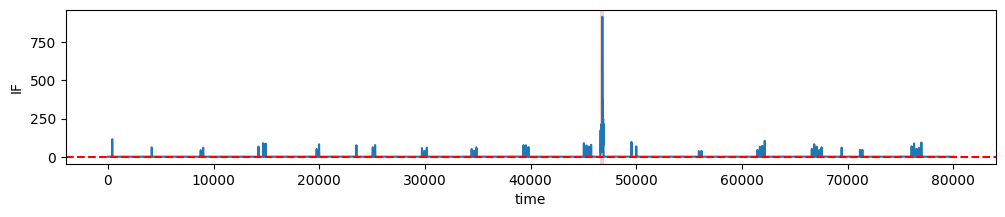

In [50]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [51]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

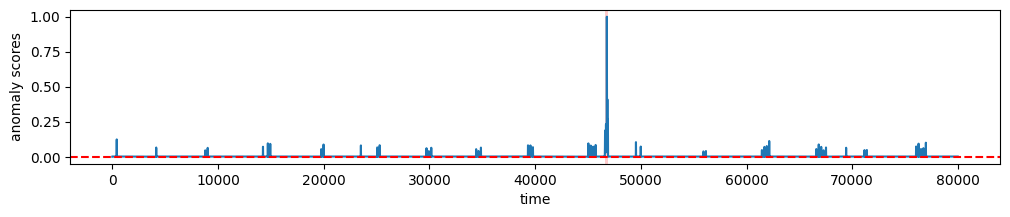

In [52]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [53]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

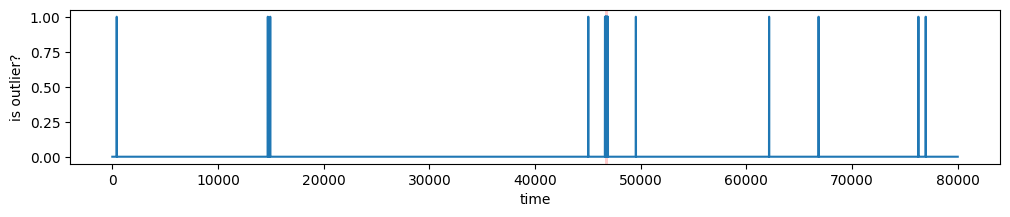

In [54]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [55]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

precision: 0.690 recall: 0.690 F1: 0.690 AUC: 0.998
